In [ ]:
pip install pyqmc --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 17.8 MB/s eta 0:00:00


In [ ]:
!pip install pyqmc scipy pandas pyscf numpy matplotlib h5py pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 13.9 MB/s eta 0:00:00


In [ ]:
# MIT License
#
# Copyright (c) 2019-2024 The PyQMC Developers
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import pytest
from pyscf import lib, gto, scf
import pyscf.pbc
import pyscf.pbc.dft
import numpy as np
#import pyscf.hci

"""
In this file, we set up several pyscf objects that can be reused across the
tests. Try to use one of these fixtures if at all possible, so our
tests don't have to keep running pyscf.
"""

@pytest.fixture(scope="module")
def LiH_sto3g_rhf():
    mol = gto.M(atom="Li 0. 0. 0.; H 0. 0. 1.5", basis="sto-3g", unit="bohr")
    mf = scf.RHF(mol).run()
    return mol, mf
    #mf_rohf = scf.ROHF(mol).run()
    #mf_uhf = scf.UHF(mol).run()


@pytest.fixture(scope="module")
def LiH_ccecp_rhf():
    mol = gto.M(atom="Li 0. 0. 0.; H 0. 0. 1.5", basis="ccecp-ccpvdz", ecp="ccecp", unit="bohr")
    mf = scf.RHF(mol).run()
    return mol, mf


@pytest.fixture(scope="module")
def LiH_sto3g_uhf():
    mol = gto.M(atom="Li 0. 0. 0.; H 0. 0. 1.5", basis="sto-3g", unit="bohr")
    mf = scf.UHF(mol).run()
    return mol, mf

@pytest.fixture(scope="module")
def H2_ccecp_rhf():
    r = 1.54 / 0.529177
    mol = gto.M(
        atom="H 0. 0. 0.; H 0. 0. %g" % r,
        ecp="ccecp",
        basis="ccecpccpvdz",
        unit="bohr",
        verbose=1,
    )
    mf = scf.RHF(mol).run()
    return mol, mf


@pytest.fixture(scope="module")
def H2_ccecp_uhf():
    r = 1.54 / 0.529177
    mol = gto.M(
        atom="H 0. 0. 0.; H 0. 0. %g" % r,
        ecp="ccecp",
        basis="ccecpccpvdz",
        unit="bohr",
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    return mol, mf


@pytest.fixture(scope="module")
def H2_ccecp_hci(H2_ccecp_rhf):
    mol, mf = H2_ccecp_rhf

    cisolver = pyscf.hci.SCI(mol)
    cisolver.select_cutoff = 0.1
    nmo = mf.mo_coeff.shape[1]
    nelec = mol.nelec
    h1 = mf.mo_coeff.T.dot(mf.get_hcore()).dot(mf.mo_coeff)
    h2 = pyscf.ao2mo.full(mol, mf.mo_coeff)
    e, civec = cisolver.kernel(h1, h2, nmo, nelec, verbose=4)
    cisolver.ci = civec[0]
    cisolver.energy = e +  mf.energy_nuc()

    return mol, mf, cisolver


@pytest.fixture(scope="module")
def H2_ccecp_casci_s0(H2_ccecp_rhf):
    mol, mf = H2_ccecp_rhf
    mc = pyscf.mcscf.CASCI(mf, ncas=4, nelecas=(1, 1))
    mc.kernel()
    return mol, mf, mc


@pytest.fixture(scope="module")
def H2_ccecp_casci_s2(H2_ccecp_uhf):
    mol, mf = H2_ccecp_uhf
    mc = pyscf.mcscf.CASCI(mf, ncas=4, nelecas=(2, 0))
    mc.kernel()
    return mol, mf, mc


@pytest.fixture(scope="module")
def H2_ccecp_casscf_s0(H2_ccecp_rhf):
    mol, mf = H2_ccecp_rhf
    mc = pyscf.mcscf.CASSCF(mf, ncas=4, nelecas=(1, 1))
    mc.kernel()
    return mol, mf, mc


@pytest.fixture(scope="module")
def H2_ccecp_casscf_s2(H2_ccecp_uhf):
    mol, mf = H2_ccecp_uhf
    mc = pyscf.mcscf.CASSCF(mf, ncas=4, nelecas=(2, 0))
    mc.kernel()
    return mol, mf, mc


@pytest.fixture(scope="module")
def H2_ccecp_uhf():
    r = 1.54 / 0.529177
    mol = gto.M(
        atom="H 0. 0. 0.; H 0. 0. %g" % r,
        ecp="ccecp",
        basis="ccecpccpvdz",
        unit="bohr",
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    return mol, mf

@pytest.fixture(scope="module")
def H2_casci():
    mol = gto.M(atom="H 0. 0. 0.0; H 0. 0. 2.4",
            basis=f"ccpvtz",
            unit="bohr",
            charge=0,
            spin=0,
            verbose=1)
    mf = scf.ROHF(mol).run()
    mc = pyscf.mcscf.CASCI(mf, 2, 2)
    mc.fcisolver.nroots = 4
    mc.kernel()
    return mol, mf, mc

@pytest.fixture(scope="module")
def C2_ccecp_rhf():
    mol = gto.M(
                atom="""C 0 0 0
                C 1 0 0  """,
                ecp="ccecp",
                basis="ccecpccpvdz",
                )
    mf = scf.RHF(mol).run()
    return mol, mf


@pytest.fixture(scope="module")
def C_ccecp_rohf():
    mol = gto.M(
                atom="""C 0 0 0
                C 1 0 0  """,
                ecp="ccecp",
                basis="ccecpccpvdz",
                spin=2
                )
    mf = scf.RHF(mol).run()
    return mol, mf


@pytest.fixture(scope='module')
def H_pbc_sto3g_krks():
    mol = pyscf.pbc.gto.M(
        atom="H 0. 0. 0.; H 1. 1. 1.",
        basis="sto-3g",
        unit="bohr",
        a=(np.ones((3, 3)) - np.eye(3)) * 4,
    )
    mf = pyscf.pbc.scf.KRKS(mol, mol.make_kpts((2, 2, 2))).run()
    return mol, mf


@pytest.fixture(scope='module')
def H_pbc_sto3g_kuks():
    mol = pyscf.pbc.gto.M(
        atom="H 0. 0. 0.; H 1. 1. 1.",
        basis="sto-3g",
        unit="bohr",
        a=(np.ones((3, 3)) - np.eye(3)) * 4,
    )
    mf = pyscf.pbc.scf.KUKS(mol, mol.make_kpts((2, 2, 2))).run()
    return mol, mf


@pytest.fixture(scope='module')
def li_cubic_ccecp():
    nk = (2,2,2)
    L = 6.63 * 2
    cell = pyscf.pbc.gto.Cell(
        atom="""Li     {0}      {0}      {0}
                  Li     {1}      {1}      {1}""".format(
            0.0, L / 4
        ),
        basis="ccecpccpvdz",
        ecp={"Li": "ccecp"},
        spin=0,
        unit="bohr",
    )
    cell.exp_to_discard = 0.1
    cell.build(a=np.eye(3) * L)
    kpts = cell.make_kpts(nk)
    mf = pyscf.pbc.scf.KRKS(cell, kpts)
    mf.xc = "pbe"
    #mf = mf.density_fit()
    #mf = pyscf.pbc.dft.multigrid.multigrid(mf)
    mf = mf.run()
    return cell, mf


@pytest.fixture(scope='module')
def diamond_primitive():
    cell = pyscf.pbc.gto.Cell()
    cell.verbose = 5
    cell.atom=[
        ['C', np.array([0., 0., 0.])],
        ['C', np.array([0.8917, 0.8917, 0.8917])]
               ]
    cell.a=[[0.0, 1.7834, 1.7834],
            [1.7834, 0.0, 1.7834],
            [1.7834, 1.7834, 0.0]]
    cell.basis = 'ccecpccpvdz'
    cell.ecp = 'ccecp'
    cell.exp_to_discard=0.3
    cell.build()
    kpts = cell.make_kpts((2,2,2))
    mf=pyscf.pbc.dft.KRKS(cell, kpts)

    mf.xc='lda,vwn'

    mf.kernel()
    return cell, mf


@pytest.fixture(scope='module')
def h_noncubic_sto3g_triplet():
    nk = (1,1,1)
    L = 8
    mol = pyscf.pbc.gto.M(
        atom="""H     {0}      {0}      {0}
                  H     {1}      {1}      {1}""".format(
            0.0, L / 4
        ),
        basis="sto-3g",
        a=(np.ones((3, 3)) - np.eye(3)) * L / 2,
        spin=2*np.prod(nk),
        unit="bohr",
    )
    kpts = mol.make_kpts(nk)
    mf = pyscf.pbc.scf.KUKS(mol, kpts)
    mf.xc = "pbe"
    #mf = pyscf.pbc.dft.multigrid.multigrid(mf)
    mf = mf.run()
    print(mf.mo_occ)
    return mol, mf


@pytest.fixture(scope='module')
def h_pbc_casscf():
    L = 8
    mol = pyscf.pbc.gto.M(
        atom="""H     {0}      {0}      {0}
                  H     {1}      {1}      {1}""".format(
            0.0, L / 4
        ),
        basis="ccpvdz",
        a= np.eye(3) * L,
        spin=0,
        unit="bohr",
        precision=1e-6,
    )
    mf = pyscf.pbc.scf.RKS(mol)
    mf.xc = "pbe"
    #mf = pyscf.pbc.dft.multigrid.multigrid(mf)
    mf = mf.run()
    print(mf.mo_occ)
    mc = pyscf.mcscf.CASSCF(mf, ncas=4, nelecas=(1, 1))
    mc.kernel()
    return mol, mf, mc

In [ ]:
# MIT License
#
# Copyright (c) 2019-2024 The PyQMC Developers
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

from pyscf import lib, gto, scf
import pyscf.pbc
import numpy as np
import pyqmc.api as pyq
import pyqmc.accumulators
from rich import print
from pyqmc.optimize_excited_states import optimize


def H2_casci():
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccpvtz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.ROHF(mol).run()
    mc = pyscf.mcscf.CASCI(mf, 2, 2)
    mc.fcisolver.nroots = 4
    mc.kernel()
    return mol, mf, mc


def run_optimization_best_practice_2states(**kwargs):
    """
    First optimize the ground state and then optimize the excited
    states while fixing the
    """

    mol, mf, mc = H2_casci()
    import copy

    mf.output = None
    mol.output = None
    mc.output = None
    mc.stdout = None
    mol.stdout = None
    mc.stdout = None
    nstates = 2
    mcs = [copy.copy(mc) for i in range(nstates)]
    for i in range(nstates):
        mcs[i].ci = mc.ci[i]

    wfs = []
    to_opts = []
    for i in range(nstates):
        wf, to_opt = pyq.generate_wf(
            mol, mf, mc=mcs[i], slater_kws=dict(optimize_determinants=True)
        )
        wfs.append(wf)
        to_opts.append(to_opt)
    configs = pyq.initial_guess(mol, 1000)

    pgrad1 = pyq.gradient_generator(mol, wfs[0], to_opt=to_opts[0])
    wfs[0], _ = pyq.line_minimization(
        wfs[0], configs, pgrad1, verbose=True, max_iterations=10
    )

    for k in to_opts[0]:
        to_opts[0][k] = np.zeros_like(to_opts[0][k])
    to_opts[0]["wf1det_coeff"][0] = True  # Bug workaround for linear transform
    for to_opt in to_opts[1:]:
        to_opt["wf1det_coeff"] = np.ones_like(to_opt["wf1det_coeff"])

    transforms = [
        pyqmc.accumulators.LinearTransform(wf.parameters, to_opt)
        for wf, to_opt in zip(wfs, to_opts)
    ]
    for wf in wfs[1:]:
        for k in wf.parameters.keys():
            if "wf2" in k:
                wf.parameters[k] = wfs[0].parameters[k].copy()
    _, configs = pyq.vmc(wfs[0], configs)
    energy = pyq.EnergyAccumulator(mol)
    return optimize(wfs, configs, energy, transforms)


if __name__ == "__main__":
    from concurrent.futures import ProcessPoolExecutor

    # with ProcessPoolExecutor(max_workers=2) as client:
    client = None
    for norm_penalty in [0.005]:

        run_optimization_best_practice_2states(
            hdf_file=f"optimize_norm{norm_penalty}.hdf5",
            max_tstep=0.1,
            diagonal_approximation=False,
            norm_relative_penalty=norm_penalty,
            client=client,
            npartitions=2,
            nsteps=200,
        )


starting warmup
finished warmup
----------vmc done
descent en -1.1347935916356149 0.003767170452346283  estimated sigma  1.191283896350106
descent |grad| 0.19535830027465592
----------vmc done
descent en -1.1604494382326331 0.0024076020308189893  estimated sigma  0.7613506116634912
descent |grad| 0.08471462970619931
----------vmc done
descent en -1.165387577536849 0.0022033769617101147  estimated sigma  0.6967689742945575
descent |grad| 0.04821992074322713
----------vmc done
descent en -1.166056353985949 0.0013693158678544342  estimated sigma  0.4330156978630154
descent |grad| 0.03486301591141967
----------vmc done
descent en -1.1694643052281557 0.001014819815264762  estimated sigma  0.32091420309079594
descent |grad| 0.030116948236628888
----------vmc done
descent en -1.1676993301876333 0.0014960344053731442  estimated sigma  0.47308761789547793
descent |grad| 0.02952967152547739
----------vmc done
descent en -1.1662235743133014 0.0012196380306936907  estimated sigma  0.38568340979544

TypeError: optimize() missing 1 required positional argument: 'hdf_file'

In [ ]:
import cupy as cp
import numpy as np

# Criar um array CuPy
cupy_array = cp.array([1, 2, 3, 4])

# Converter para NumPy explicitamente
numpy_array = cupy_array.get()

print(numpy_array)


[1 2 3 4]

In [ ]:
def run_optimization_best_practice_2states(hdf_file, **kwargs):
    """
    Primeiro otimiza o estado fundamental e então otimiza os estados excitados
    enquanto fixa os coeficientes de determinantes no estado fundamental.
    """

    mol, mf, mc = H2_casci()
    import copy

    mf.output = None
    mol.output = None
    mc.output = None
    mc.stdout = None
    mol.stdout = None
    mc.stdout = None
    nstates = 2
    mcs = [copy.copy(mc) for _ in range(nstates)]
    for i in range(nstates):
        mcs[i].ci = mc.ci[i]

    wfs = []
    to_opts = []
    for i in range(nstates):
        wf, to_opt = pyq.generate_wf(
            mol, mf, mc=mcs[i], slater_kws=dict(optimize_determinants=True)
        )
        wfs.append(wf)
        to_opts.append(to_opt)
    configs = pyq.initial_guess(mol, 1000)

    pgrad1 = pyq.gradient_generator(mol, wfs[0], to_opt=to_opts[0])
    wfs[0], _ = pyq.line_minimization(
        wfs[0], configs, pgrad1, verbose=True, max_iterations=10
    )

    for k in to_opts[0]:
        to_opts[0][k] = np.zeros_like(to_opts[0][k])
    to_opts[0]["wf1det_coeff"][0] = True  # Bug workaround for linear transform
    for to_opt in to_opts[1:]:
        to_opt["wf1det_coeff"] = np.ones_like(to_opt["wf1det_coeff"])

    transforms = [
        pyqmc.accumulators.LinearTransform(wf.parameters, to_opt)
        for wf, to_opt in zip(wfs, to_opts)
    ]
    for wf in wfs[1:]:
        for k in wf.parameters.keys():
            if "wf2" in k:
                wf.parameters[k] = wfs[0].parameters[k].copy()
    _, configs = pyq.vmc(wfs[0], configs)
    energy = pyq.EnergyAccumulator(mol)

    # Garantir que os dados são arrays NumPy antes de passar para a função optimize
    configs = np.asarray(configs)

    return optimize(wfs, configs, energy, transforms, hdf_file=hdf_file)

if __name__ == "__main__":
    from concurrent.futures import ProcessPoolExecutor

    # Definição do caminho do arquivo HDF5
    hdf_file_path = "optimize_norm0.005.hdf5"

    # Executa a otimização com o caminho do arquivo HDF5
    run_optimization_best_practice_2states(
        hdf_file=hdf_file_path,
        max_tstep=0.1,
        client=None,
        npartitions=2,
        nsteps=200,
    )


starting warmup
finished warmup
----------vmc done
descent en -1.1309224787221743 0.0031483898228995212  estimated sigma  0.9956082802456637
descent |grad| 0.19706714985130674
----------vmc done
descent en -1.1579354290208999 0.0017641077909082263  estimated sigma  0.5578598657318075
descent |grad| 0.0863972810502929
----------vmc done
descent en -1.164943531818091 0.0019857275462695835  estimated sigma  0.6279421858749276
descent |grad| 0.04883332270969485
----------vmc done
descent en -1.1635928517887981 0.0017432658126770295  estimated sigma  0.5512690535163846
descent |grad| 0.03525858344408083
----------vmc done
descent en -1.169159950459485 0.001264087724126973  estimated sigma  0.3997396370499816
descent |grad| 0.024108990575683442
----------vmc done
descent en -1.1682509534541548 0.0013947189568189425  estimated sigma  0.44104885993618886
descent |grad| 0.020909543732711536
----------vmc done
descent en -1.1690837293960803 0.000946216408422193  estimated sigma  0.29921990100382

AttributeError: 'numpy.ndarray' object has no attribute 'configs'

In [ ]:
# Ler o arquivo HDF5
with h5py.File('/content/optimize_norm0.005.hdf5', 'r') as file:
    # Acessar o grupo
    group = file['my_group']

    # Acessar o dataset
    dataset = group['my_dataset']

    # Ler os dados do dataset
    data = dataset[:]

    # Ler o atributo
    description = dataset.attrs['description']
    print(description)

NameError: name 'h5py' is not defined

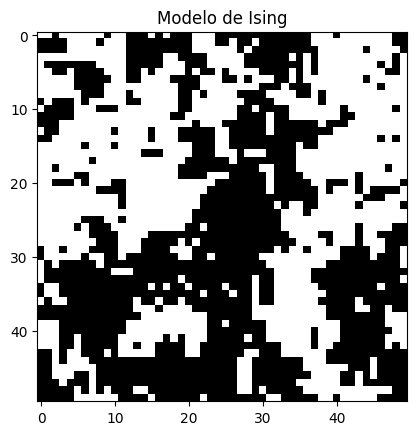

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Funções auxiliares para o modelo de Ising
def initialize_lattice(size):
    """ Inicializa uma rede de spins aleatória. """
    return np.random.choice([-1, 1], size=(size, size))

def calculate_energy(lattice, J=1):
    """ Calcula a energia total da rede. """
    energy = 0
    size = lattice.shape[0]
    for i in range(size):
        for j in range(size):
            S = lattice[i, j]
            # Vizinhos
            neighbors = lattice[(i+1)%size, j] + lattice[i, (j+1)%size] + \
                        lattice[(i-1)%size, j] + lattice[i, (j-1)%size]
            energy -= J * S * neighbors
    return energy / 2.0

def metropolis_step(lattice, beta):
    """ Executa um passo de Metropolis. """
    size = lattice.shape[0]
    i, j = np.random.randint(0, size, 2)
    S = lattice[i, j]
    neighbors = lattice[(i+1)%size, j] + lattice[i, (j+1)%size] + \
                lattice[(i-1)%size, j] + lattice[i, (j-1)%size]
    delta_E = 2 * S * neighbors
    if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
        lattice[i, j] *= -1

def update_lattice(lattice, beta):
    """ Atualiza a rede com múltiplos passos de Metropolis. """
    size = lattice.shape[0]
    for _ in range(size**2):
        metropolis_step(lattice, beta)

def animate(i, lattice, beta, im):
    """ Função de animação. """
    update_lattice(lattice, beta)
    im.set_array(lattice)  # Atualiza os dados da imagem para a matriz 2D
    return [im]

# Parâmetros da simulação
size = 50
beta = 0.4  # Parâmetro de inverso da temperatura
n_frames = 100

# Inicializar a rede
lattice = initialize_lattice(size)

# Configurar a animação
fig, ax = plt.subplots()
im = ax.imshow(lattice, cmap='gray', vmin=-1, vmax=1, interpolation='none')
ax.set_title("Modelo de Ising")

ani = animation.FuncAnimation(fig, animate, frames=n_frames, fargs=(lattice, beta, im),
                              interval=50, blit=True)

# Salvar a animação em um arquivo MP4
ani.save('ising_model_animation.mp4', writer='ffmpeg')

plt.show()


  0%|          | 0/165 [00:00<?, ?it/s]

It took 32.34 minutes to execute the code


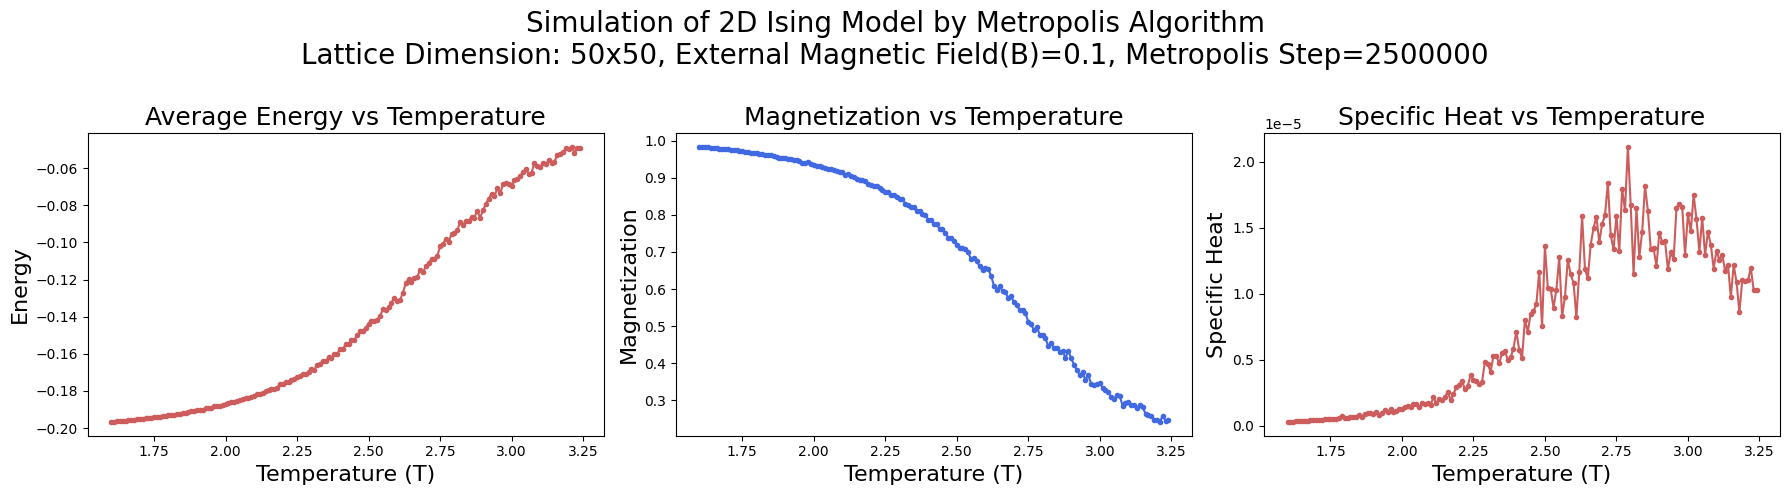

In [1]:
# coding: utf-8
# ----------------------------------------------------------------------
# 2d Ising model Monte-Carlo Simulation
# Author: Mohamed Elashri
# Email: elashrmr@mail.uc.edu
# Algorithm
#  1- Prepare some initial configrations of N spins.
#  2- Flip spin of a lattice site chosen randomly
#  3- Calculate the change in energy due to that
#  4- If this change is negative, accept such move. If change is positive, accept it with probability exp^{-dE/kT}
#  5- repeat 2-4.
# 6- calculate Other parameters and plot them
# ----------------------------------------------------------------------

"""
Lattice is a periodical structure of points that align one by one. 2D lattice can be plotted as:

* * * * * * * *
* * * * * * * *
* * * * * * * *
* * * * * * * *
* * * * * * * *

The points in lattice are called lattice points, neareast lattice points of point ^
are those lattice points denoted by (*) shown in the graph below:

* * *(*)* * * *
* *(*)^(*)* * *
* * *(*)* * * *
* * * * * * * *

Each lattice point is denoted by a number i in the Harmitonian.

The expression for the Energy of the total system is (online latex formula)
https://melashri.net/url/a or
(H = - J \sum_{ i = 0 }^{ N-1 }\sum_{ j = 0 }^{ N-1 } (s_{i,j}s_{i,j+1}+s_{i,j}s_{i+1,j}) )

* * * * * * * *
* * * * * * * *
* * * * * * * * <-the i-th lattice point
* * * * * * * *
* * * * * * * *

Periodical strcture means that lattice point at(1,1) is the same as that at(1,9) if the lattice is 5 by 8.
more e.g.(1,1)<=>(6,1),(2,3)<=>(2,11). A 2D lattice can be any Nx by Ny. The location (x,y)
here is another denotion of lattice point that is fundementally same as i-th lattice point denotation above.s

* * * * * * * * 4
* * * * * * * * 3
* * * * * * * * 2
* * * * * * * * 1
1 2 3 4 5 6 7 8

"""

# ----------------------------------------------------------------------
#  Import needed python libraries
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from numba import jit
from tqdm.notebook import tqdm

def initialize_lattice(L):
    """Initialize the lattice with random spin sites (+1 or -1) for up or down spins."""
    return np.random.choice([1, -1], size=(L, L))

@jit(nopython=True, cache=True)
def calcE(s, L, B, mu):
    """Calculate the energy of the lattice."""
    E = 0
    for i in range(L):
        for j in range(L):
            E += -dE(s, i, j, L, B, mu, include_neighbor_interaction=False) / 2
    E -= mu * B * s.sum()  # Magnetic field contribution
    return E / L ** 2

@jit(nopython=True)
def calcM(s, L):
    """Calculate the magnetization of a given configuration."""
    m = np.abs(s.sum())
    return m / L**2

@jit(nopython=True, cache=True)
def dE(s, i, j, L, B, mu, include_neighbor_interaction=True):
    """Calculate the interaction energy between spins."""
    t = s[i - 1 if i > 0 else L - 1, j]
    b = s[i + 1 if i < L - 1 else 0, j]
    l = s[i, j - 1 if j > 0 else L - 1]
    r = s[i, j + 1 if j < L - 1 else 0]

    neighbor_interaction = 2 * s[i, j] * (t + b + l + r) if include_neighbor_interaction else 0
    magnetic_contribution = 2 * mu * B * s[i, j]

    return neighbor_interaction + magnetic_contribution

@jit(nopython=True)
def mc(s, Temp, n, L, B, mu):
    """Perform Monte-Carlo sweeps."""
    for _ in range(n):
        i = random.randrange(L)  # Choose random row
        j = random.randrange(L)  # Choose random column
        ediff = dE(s, i, j, L, B, mu)
        if ediff <= 0:  # If the change in energy is negative
            s[i, j] = -s[i, j]  # Accept move and flip spin
        elif random.random() < np.exp(-ediff / Temp):  # Accept with probability exp(-dU/kT)
            s[i, j] = -s[i, j]
    return s

@jit(nopython=True)
def physics(s, T, n, L, B, mu):
    """Compute physical quantities."""
    En = 0
    En_sq = 0
    Mg = 0
    Mg_sq = 0
    for _ in range(n):
        s = mc(s, T, 1, L, B, mu)
        E = calcE(s, L, B, mu)
        M = calcM(s, L)
        En += E
        Mg += M
        En_sq += E * E
        Mg_sq += M * M
    En_avg = En / n
    mag = Mg / n
    CV = (En_sq / n - (En / n)**2) / (T**2)
    return En_avg, mag, CV

def simulate_ising_model(L, n, Temperature, B, mu):
    """Simulate the Ising model and compute physical quantities."""
    s = initialize_lattice(L)

    mag = np.zeros(len(Temperature))
    En_avg = np.zeros(len(Temperature))
    CV = np.zeros(len(Temperature))

    start = time.time()

    for ind, T in enumerate(tqdm(Temperature)):
        s = mc(s, T, n, L, B, mu)
        En_avg[ind], mag[ind], CV[ind] = physics(s, T, n, L, B, mu)

    end = time.time()
    elapsed_time = (end - start) / 60
    print(f'It took {elapsed_time:.2f} minutes to execute the code')

    return En_avg, mag, CV

def plot_results(En_avg, mag, CV, L, n, B, Temperature):
    """Plot the simulation results."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(Temperature, En_avg, marker='.', color='IndianRed')
    axes[0].set_xlabel("Temperature (T)", fontsize=16)
    axes[0].set_ylabel("Energy", fontsize=16)
    axes[0].set_title("Average Energy vs Temperature", fontsize=18)

    axes[1].plot(Temperature, abs(mag), marker='.', color='RoyalBlue')
    axes[1].set_xlabel("Temperature (T)", fontsize=16)
    axes[1].set_ylabel("Magnetization", fontsize=16)
    axes[1].set_title("Magnetization vs Temperature", fontsize=18)

    axes[2].plot(Temperature, CV, marker='.', color='IndianRed')
    axes[2].set_xlabel("Temperature (T)", fontsize=16)
    axes[2].set_ylabel("Specific Heat", fontsize=16)
    axes[2].set_title("Specific Heat vs Temperature", fontsize=18)

    plt.suptitle(f"Simulation of 2D Ising Model by Metropolis Algorithm\n"
                 f"Lattice Dimension: {L}x{L}, External Magnetic Field(B)={B}, Metropolis Step={n}",
                 fontsize=20)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
#                                Usage
# ----------------------------------------------------------------------


# Define parameters
L = 50  # Lattice size (width)
n = 1000 * L**2  # Number of MC sweeps
Temperature = np.arange(1.6, 3.25, 0.01)  # Temperature range (includes critical temperature)
B = 0.1  # Strength of the magnetic field
mu = 1  # Magnetic moment of each spin

# Run the simulation and plot the results
En_avg, mag, CV = simulate_ising_model(L, n, Temperature, B, mu)
plot_results(En_avg, mag, CV, L, n, B, Temperature)

  0%|          | 0/165 [00:00<?, ?it/s]

Levou 32.27 minutos para executar o código


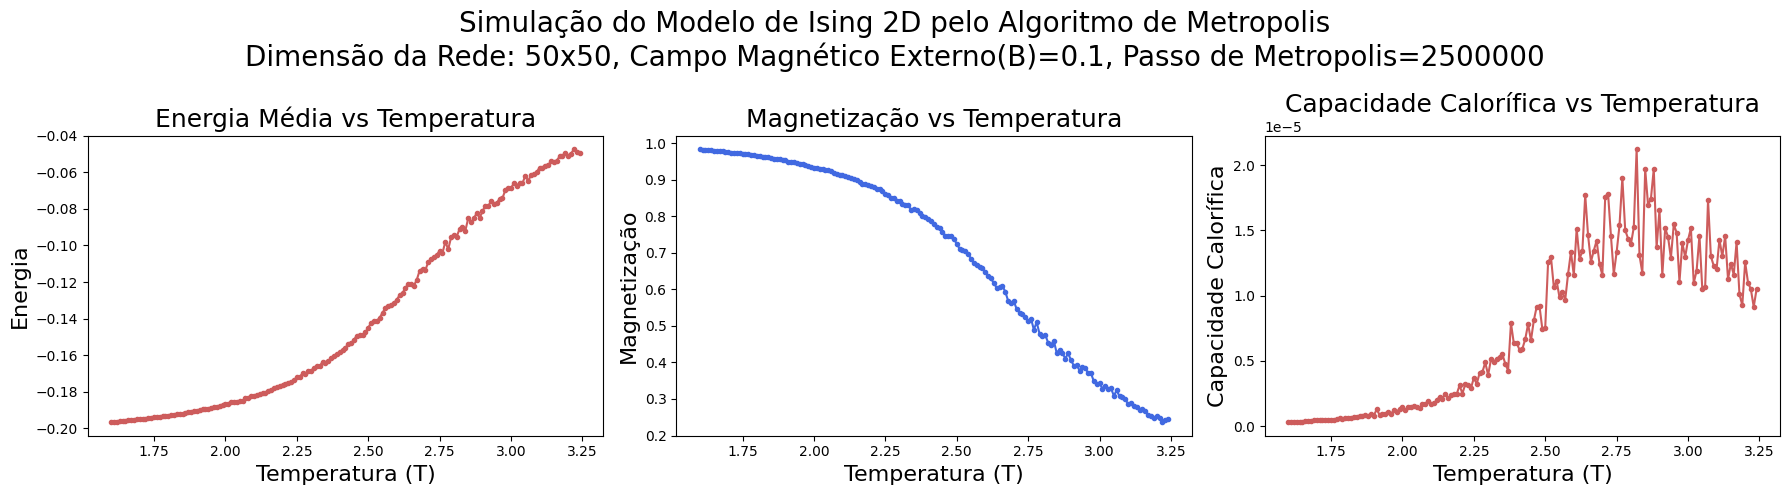

In [2]:
# coding: utf-8
# ----------------------------------------------------------------------
# Simulação Monte-Carlo do modelo de Ising 2D
# Autor: Mohamed Elashri
# Email: elashrmr@mail.uc.edu
# Algoritmo
#  1- Prepare algumas configurações iniciais de N spins.
#  2- Inverta o spin de um ponto da rede escolhido aleatoriamente.
#  3- Calcule a mudança na energia devido a isso.
#  4- Se essa mudança for negativa, aceite o movimento. Se a mudança for positiva, aceite com probabilidade exp^{-dE/kT}.
#  5- Repita os passos 2-4.
# 6- Calcule outros parâmetros e plote-os.
# ----------------------------------------------------------------------

"""
A rede é uma estrutura periódica de pontos que se alinham um a um. A rede 2D pode ser plotada como:

* * * * * * * *
* * * * * * * *
* * * * * * * *
* * * * * * * *
* * * * * * * *

Os pontos na rede são chamados de pontos de rede, e os pontos de rede mais próximos do ponto ^
são aqueles pontos de rede denotados por (*) mostrados no gráfico abaixo:

* * *(*)* * * *
* *(*)^(*)* * *
* * *(*)* * * *
* * * * * * * *

Cada ponto de rede é denotado por um número i no Hamiltoniano.

A expressão para a energia do sistema total é (fórmula online em LaTeX)
https://melashri.net/url/a ou
(H = - J \sum_{ i = 0 }^{ N-1 }\sum_{ j = 0 }^{ N-1 } (s_{i,j}s_{i,j+1}+s_{i,j}s_{i+1,j}) )

* * * * * * * *
* * * * * * * *
* * * * * * * * <-o i-ésimo ponto de rede
* * * * * * * *
* * * * * * * *

Estrutura periódica significa que o ponto de rede em (1,1) é o mesmo que o ponto em (1,9) se a rede é 5 por 8.
Mais exemplos: (1,1)<=>(6,1), (2,3)<=>(2,11). Uma rede 2D pode ser qualquer Nx por Ny. A localização (x,y)
aqui é outra denotação do ponto de rede que é fundamentalmente a mesma que a denotação do ponto de rede i-ésimo acima.

* * * * * * * * 4
* * * * * * * * 3
* * * * * * * * 2
* * * * * * * * 1
1 2 3 4 5 6 7 8

"""

# ----------------------------------------------------------------------
#  Importar bibliotecas Python necessárias
# ----------------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from numba import jit
from tqdm.notebook import tqdm

def initialize_lattice(L):
    """Inicializa a rede com pontos de spin aleatórios (+1 ou -1) para spins para cima ou para baixo."""
    return np.random.choice([1, -1], size=(L, L))

@jit(nopython=True, cache=True)
def calcE(s, L, B, mu):
    """Calcula a energia da rede."""
    E = 0
    for i in range(L):
        for j in range(L):
            E += -dE(s, i, j, L, B, mu, include_neighbor_interaction=False) / 2
    E -= mu * B * s.sum()  # Contribuição do campo magnético
    return E / L ** 2

@jit(nopython=True)
def calcM(s, L):
    """Calcula a magnetização de uma configuração dada."""
    m = np.abs(s.sum())
    return m / L**2

@jit(nopython=True, cache=True)
def dE(s, i, j, L, B, mu, include_neighbor_interaction=True):
    """Calcula a energia de interação entre spins."""
    t = s[i - 1 if i > 0 else L - 1, j]
    b = s[i + 1 if i < L - 1 else 0, j]
    l = s[i, j - 1 if j > 0 else L - 1]
    r = s[i, j + 1 if j < L - 1 else 0]

    neighbor_interaction = 2 * s[i, j] * (t + b + l + r) if include_neighbor_interaction else 0
    magnetic_contribution = 2 * mu * B * s[i, j]

    return neighbor_interaction + magnetic_contribution

@jit(nopython=True)
def mc(s, Temp, n, L, B, mu):
    """Realiza as varreduras de Monte-Carlo."""
    for _ in range(n):
        i = random.randrange(L)  # Escolhe uma linha aleatória
        j = random.randrange(L)  # Escolhe uma coluna aleatória
        ediff = dE(s, i, j, L, B, mu)
        if ediff <= 0:  # Se a mudança na energia for negativa
            s[i, j] = -s[i, j]  # Aceite o movimento e inverta o spin
        elif random.random() < np.exp(-ediff / Temp):  # Aceite com probabilidade exp(-dU/kT)
            s[i, j] = -s[i, j]
    return s

@jit(nopython=True)
def physics(s, T, n, L, B, mu):
    """Calcula as quantidades físicas."""
    En = 0
    En_sq = 0
    Mg = 0
    Mg_sq = 0
    for _ in range(n):
        s = mc(s, T, 1, L, B, mu)
        E = calcE(s, L, B, mu)
        M = calcM(s, L)
        En += E
        Mg += M
        En_sq += E * E
        Mg_sq += M * M
    En_avg = En / n
    mag = Mg / n
    CV = (En_sq / n - (En / n)**2) / (T**2)
    return En_avg, mag, CV

def simulate_ising_model(L, n, Temperature, B, mu):
    """Simula o modelo de Ising e calcula as quantidades físicas."""
    s = initialize_lattice(L)

    mag = np.zeros(len(Temperature))
    En_avg = np.zeros(len(Temperature))
    CV = np.zeros(len(Temperature))

    start = time.time()

    for ind, T in enumerate(tqdm(Temperature)):
        s = mc(s, T, n, L, B, mu)
        En_avg[ind], mag[ind], CV[ind] = physics(s, T, n, L, B, mu)

    end = time.time()
    elapsed_time = (end - start) / 60
    print(f'Levou {elapsed_time:.2f} minutos para executar o código')

    return En_avg, mag, CV

def plot_results(En_avg, mag, CV, L, n, B, Temperature):
    """Plota os resultados da simulação."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(Temperature, En_avg, marker='.', color='IndianRed')
    axes[0].set_xlabel("Temperatura (T)", fontsize=16)
    axes[0].set_ylabel("Energia", fontsize=16)
    axes[0].set_title("Energia Média vs Temperatura", fontsize=18)

    axes[1].plot(Temperature, abs(mag), marker='.', color='RoyalBlue')
    axes[1].set_xlabel("Temperatura (T)", fontsize=16)
    axes[1].set_ylabel("Magnetização", fontsize=16)
    axes[1].set_title("Magnetização vs Temperatura", fontsize=18)

    axes[2].plot(Temperature, CV, marker='.', color='IndianRed')
    axes[2].set_xlabel("Temperatura (T)", fontsize=16)
    axes[2].set_ylabel("Capacidade Calorífica", fontsize=16)
    axes[2].set_title("Capacidade Calorífica vs Temperatura", fontsize=18)

    plt.suptitle(f"Simulação do Modelo de Ising 2D pelo Algoritmo de Metropolis\n"
                 f"Dimensão da Rede: {L}x{L}, Campo Magnético Externo(B)={B}, Passo de Metropolis={n}",
                 fontsize=20)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------
#                                Uso
# ----------------------------------------------------------------------


# Defina os parâmetros
L = 50  # Tamanho da rede (largura)
n = 1000 * L**2  # Número de varreduras de MC
Temperature = np.arange(1.6, 3.25, 0.01)  # Faixa de temperatura (inclui temperatura crítica)
B = 0.1  # Intensidade do campo magnético
mu = 1  # Momento magnético de cada spin

# Execute a simulação e plote os resultados
En_avg, mag, CV = simulate_ising_model(L, n, Temperature, B, mu)
plot_results(En_avg, mag, CV, L, n, B, Temperature)


In [4]:
!pip install ising

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


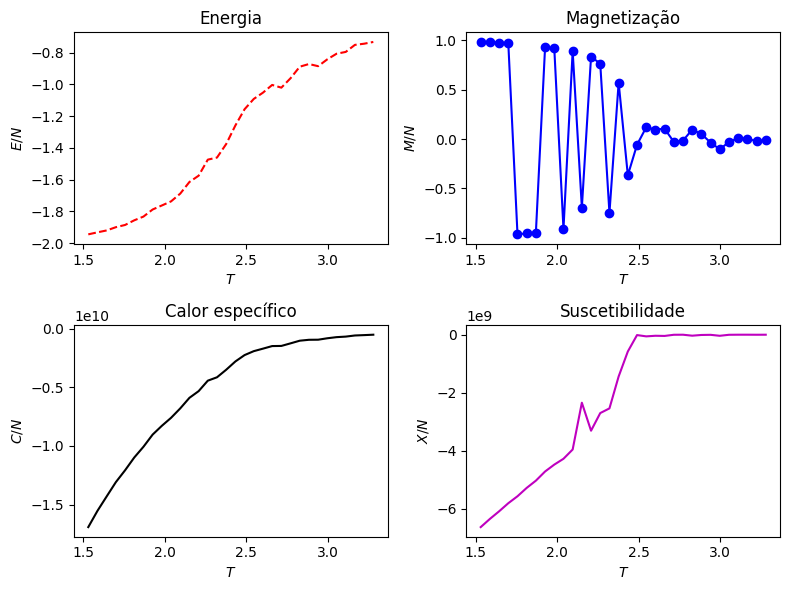

In [6]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

def estado_inicial(N):
    '''Gera uma configuração aleatória de spins para a condição inicial'''
    estado = 2 * np.random.randint(2, size=(N, N)) - 1
    return estado

def movimento_mc(config, beta):
    '''Movimento de Monte Carlo usando o algoritmo de Metropolis'''
    for i in range(N):
        for j in range(N):
            a = np.random.randint(0, N)
            b = np.random.randint(0, N)
            s = config[a, b]
            nb = config[(a+1)%N, b] + config[a, (b+1)%N] + config[(a-1)%N, b] + config[a, (b-1)%N]
            custo = 2 * s * nb

            if custo < 0:
                s *= -1
            elif rand() < np.exp(-custo * beta):
                s *= -1
            config[a, b] = s
    return config

def calcEnergia(config):
    '''Energia de uma configuração dada'''
    energia = 0
    for i in range(len(config)):
        for j in range(len(config)):
            S = config[i, j]
            nb = config[(i+1)%N, j] + config[i, (j+1)%N] + config[(i-1)%N, j] + config[i, (j-1)%N]
            energia += -nb * S
    return energia / 2.  # para compensar a contagem excessiva

def calcMag(config):
    '''Magnetização de uma configuração dada'''
    mag = np.sum(config)
    return mag

nt = 32          # número de pontos de temperatura
N = 10           # tamanho da rede, N x N
eqSteps = 2**8   # número de varreduras MC para equilíbrio
mcSteps = 2**10  # número de varreduras MC para cálculo

T = np.linspace(1.53, 3.28, nt)
E, M, C, X = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt)
n1, n2 = 1.0/(mcSteps*N*N), 1.0/(mcSteps*mcSteps*N*N)

for tt in range(nt):
    config = estado_inicial(N)

    E1 = M1 = E2 = M2 = 0
    iT = 1.0 / T[tt]
    iT2 = iT * iT

    for i in range(eqSteps):
        movimento_mc(config, iT)

    for i in range(mcSteps):
        movimento_mc(config, iT)
        Ene = calcEnergia(config)
        Mag = calcMag(config)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

    E[tt] = E1 * n1
    M[tt] = M1 * n1
    C[tt] = (E2 - E1 * E1) * iT2
    X[tt] = (M2 - M1 * M1) * iT

plt.figure(figsize=(8,6))
plt.subplot(221)
plt.plot(T, E, 'r--')
plt.xlabel(r'$T$')
plt.ylabel(r'$E/N$')
plt.title('Energia')

plt.subplot(222)
plt.plot(T, M, 'bo-')
plt.xlabel(r'$T$')
plt.ylabel(r'$M/N$')
plt.title('Magnetização')

plt.subplot(223)
plt.plot(T, C, 'k-')
plt.xlabel(r'$T$')
plt.ylabel(r'$C/N$')
plt.title('Calor específico')

plt.subplot(224)
plt.plot(T, X, 'm-')
plt.xlabel(r'$T$')
plt.ylabel(r'$X/N$')
plt.title('Suscetibilidade')

plt.tight_layout()
plt.show()


In [9]:
%matplotlib inline
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

In [10]:
#----------------------------------------------------------------------
##  BLOCK OF FUNCTIONS USED IN THE MAIN CODE
#----------------------------------------------------------------------

def initialstate(N):
    ''' generates a random spin configuration for initial condition'''
    # NxN matrix with random inters -1,1
    state = 2*np.random.randint(2, size=(1,N))-1
    return state


def mcmove(config, beta):
    '''Monte Carlo move using Metropolis algorithm '''

    #Config is the NxN spin matrix configuration
    #In each iteration NxN updates

    for i in range(N):
        b = np.random.randint(0, N)
        s =  config[0,b]
        nb = config[0,(b+1)%N] + config[0,(b-1)%N]
        #print nb
        cost = 2*s*nb
        if cost < 0:
            s *= -1
        elif rand() < np.exp(-cost*beta):
            s *= -1
        config[0,b] = s
    #print config
    return config


def calcEnergy(config):
    '''Energy of a given configuration'''
    energy = 0
    for i in range(N):
        S = config[0,i]
        nb = config[0,(i+1)%N] + config[0,(i-1)%N]
        #print nb
        energy += -nb*S
    return energy/2.    #Divide by 4 ensures , avoid multiple counting


def calcMag(config):
    '''Magnetization of a given configuration'''
    #magnetiation is just sum of all spins \sum_{i} S_i
    mag = np.sum(np.sum(config))
    return mag

In [11]:
## change the parameter below if you want to simulate a smaller system
nt      = 2**4        # number of temperature points
N       = 2**4        # size of the lattice, N
eqSteps = 2**8       # number of MC sweeps for equilibration
mcSteps = 2**8       # number of MC sweeps for calculation

n1, n2  = 1.0/(mcSteps*N*1), 1.0/(mcSteps*mcSteps*N*1)

#tm is the transition temperature
T=np.linspace(.01, 4, nt)

Energy       = np.zeros(nt);   Magnetization  = np.zeros(nt)
SpecificHeat = np.zeros(nt);   Susceptibility = np.zeros(nt)


#----------------------------------------------------------------------
#  MAIN PART OF THE CODE
#----------------------------------------------------------------------

#m is the temperature index

for m in range(len(T)):

    config = initialstate(N)
    iT=1.0/T[m]; iT2=iT*iT;

    for l in range(eqSteps):         # equilibrate
        mcmove(config, iT)           # Monte Carlo moves

    #Calculate quantities post equilibriation
    E1 = M1 = E2 = M2 = 0
    for i in range(mcSteps):
        mcmove(config, iT)
        Ene = calcEnergy(config)     # calculate the energy
        Mag = calcMag(config)        # calculate the magnetisation

        E1 = E1 + Ene                 #Cumulative energy
        M1 = M1 + Mag
        M2 = M2 + Mag*Mag
        E2 = E2 + Ene*Ene

        Energy[m]         = n1*E1     #Weighing for MC averages.
        Magnetization[m]  = n1*M1
        SpecificHeat[m]   = (n1*E2 - n2*E1*E1)*iT2
        Susceptibility[m] = (n1*M2 - n2*M1*M1)*iT2

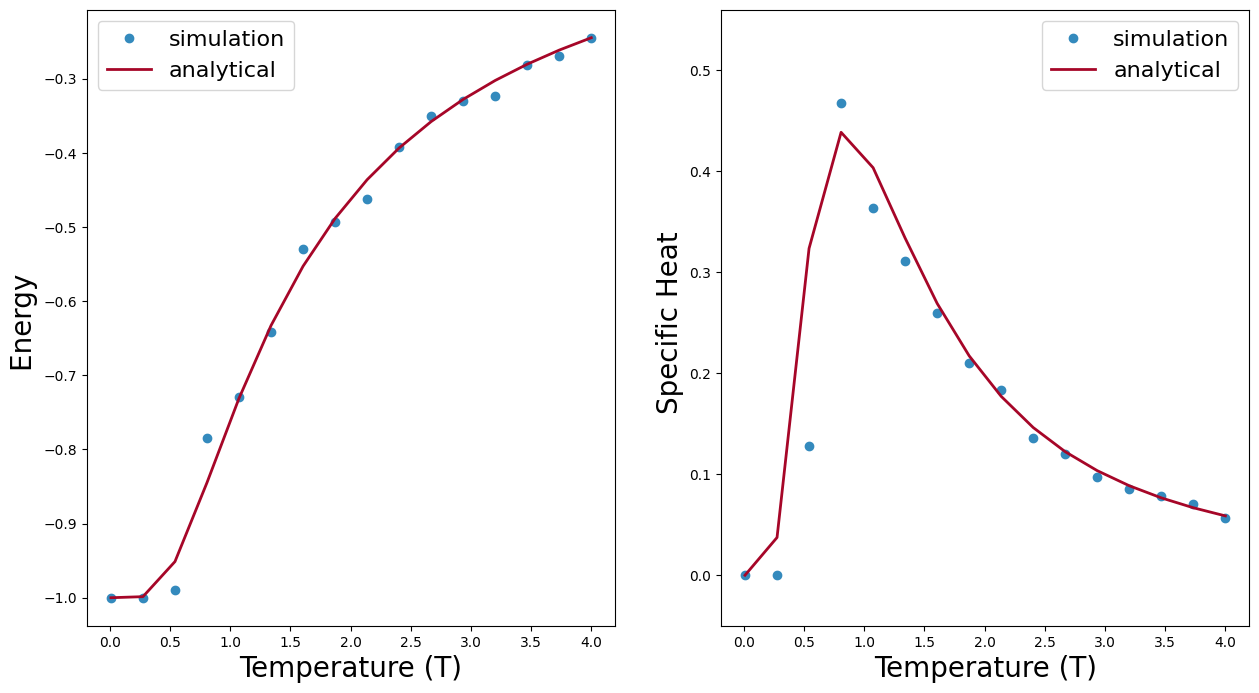

In [12]:
f = plt.figure(figsize=(15, 8)); # plot the calculated values

sp =  f.add_subplot(1, 2, 1 );
plt.plot(T, Energy, 'o', color="#348ABD", label='simulation');
plt.plot(T, -np.tanh(1.0/T), color="#A60628", lw=2,label='analytical')
plt.xlabel("Temperature (T)", fontsize=20);
plt.ylabel("Energy ", fontsize=20); plt.legend(fontsize=16)


sp =  f.add_subplot(1, 2, 2 );
plt.plot(T, SpecificHeat, 'o', color="#348ABD", label='simulation');
plt.plot(T, (1.0/T**2)*(np.cosh(1.0/T))**(-2), color="#A60628", lw=2,label='analytical')
plt.xlabel("Temperature (T)", fontsize=20); plt.ylim([-0.05, .56])
plt.ylabel("Specific Heat ", fontsize=20);  plt.legend(fontsize=16)